In [1]:
#testing reaction network code
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
#from reaction_nets import rxn_net
from functools import partial
import random
#from modified_reaction_nets import random_rxn_net
from reaction_nets_numpy import random_rxn_net
import turning_points
from pybaselines import Baseline
import scipy
import scipy.signal
from scipy.signal import savgol_filter
from analyze_turning_points import load_turning_points_from_text, load_profiles_from_text, profiles_to_turning_points
import turning_points_inputs

In [2]:
def count_turning_points_w_plot(data,all_features, window_length=11, polyorder=2, min_width=5):
    
    if len(data) < window_length:
        window_length = max(min(len(data) - 2, 7), 3)
    window_length = window_length if window_length % 2 == 1 else window_length - 1
    polyorder = min(polyorder, window_length - 2)
    # Apply Savitzky-Golay filter to smooth the data
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    #plt.plot(all_features, data, 'b-', alpha=0.7, label='Original data')
    plt.scatter(all_features, data, color='black', label='unsmoothed')

    data = savgol_filter(data, window_length, polyorder)
    plt.plot(all_features, data, 'r-', linewidth=2, label='smoothed')
    min_prominence=0.1*np.max(data)

    # Find peaks based on prominence criterion
    prominence_peaks, _ = scipy.signal.find_peaks(data, prominence=min_prominence)
    prominence_troughs, _ = scipy.signal.find_peaks(-data, prominence=min_prominence)
    
    # Find peaks based on width criterion
    width_peaks, _ = scipy.signal.find_peaks(data, width=min_width)
    width_troughs, _ = scipy.signal.find_peaks(-data, width=min_width)

    # Combine unique peaks and troughs from both criteria
    all_peaks = np.unique(np.concatenate((prominence_peaks, width_peaks)))
    all_troughs = np.unique(np.concatenate((prominence_troughs, width_troughs)))
    
    bad_points = ~np.isfinite(data)
    
    # Expand the mask to include neighbors of bad points
    bad_points_expanded = bad_points.copy()
    
    # Mark neighbors of bad points as bad too
    for i in range(len(bad_points)):
        if bad_points[i]:
            # Mark left neighbor as bad
            if i > 0:
                bad_points_expanded[i-1] = True
            # Mark right neighbor as bad  
            if i < len(bad_points) - 1:
                bad_points_expanded[i+1] = True
    
    # FILTER PEAKS AND TROUGHS
    # Remove peaks that are at bad points or next to bad points
    valid_peaks = all_peaks[~bad_points_expanded[all_peaks]]
    valid_troughs = all_troughs[~bad_points_expanded[all_troughs]]

    print(valid_peaks, data[valid_peaks])
    print(valid_troughs, data[valid_troughs])

    finite_peaks = np.isfinite(data[valid_peaks])  # boolean array, True for finite values
    count_finite_peaks = np.sum(finite_peaks)

    # Count finite values in all_troughs
    finite_troughs = np.isfinite(data[valid_troughs])
    count_finite_troughs = np.sum(finite_troughs)

    peaks_to_plot=valid_peaks[np.where(finite_peaks)]
    troughs_to_plot=valid_troughs[np.where(finite_troughs)]
    
    print(peaks_to_plot)
    print(troughs_to_plot)
    print('widths')
    print(scipy.signal.peak_widths(data, peaks_to_plot)[0])
    print(scipy.signal.peak_widths(-data, troughs_to_plot)[0])
    print('prominences')
    print(scipy.signal.peak_prominences(data, peaks_to_plot)[0])
    print(scipy.signal.peak_prominences(-data, troughs_to_plot)[0])

    if finite_peaks.shape[0] > 0:
        print('num finite peaks: ', finite_peaks.shape[0])
        plt.scatter(all_features[peaks_to_plot], data[peaks_to_plot], color='red', s=100, zorder=5, label=f'{len(all_peaks)} peaks')
    if finite_troughs.shape[0] > 0:
        print('num finite troughs', finite_troughs.shape[0])
        plt.scatter(all_features[troughs_to_plot], data[troughs_to_plot], color='green', s=100, zorder=5, label=f'{len(all_troughs)} troughs')
        print('plotted at: ', all_features[troughs_to_plot], data[troughs_to_plot])
    #for j in all_peaks:
    #    plt.axvline(all_features[j])
    #for j in all_troughs:
    #    plt.axvline(all_features[j])
    #plt.legend()

    #    Total finite values in both arrays
    total_finite = count_finite_peaks + count_finite_troughs
    print('total finite: ', total_finite)

    return total_finite

In [3]:
n=6
m=int(n*(n-1)/2)
n_second_order=2
suffix=f'task{n_second_order}'
profiles_filename = f'../data/turning_points/run_with_100/N{n}_M{m}_S{n_second_order}_profiles_{suffix}.txt'
turning_points_filename = f'../data/turning_points/run_with_100/N{n}_M{m}_S{n_second_order}_distributions_{suffix}.txt'

n_profiles=100#10000
n_features=100
n_species=6
    
#turning_points=load_profiles_from_text(profiles_filename, n_profiles, n_features, n_species)
profiles, seeds=load_profiles_from_text(profiles_filename, n_features, n_species)

20001,0.3851947634631461,0.027327788231750232,0.25905949610262413,0.23280008549907924,0.03178697175901286,0.06383179869308146,0.3798436894285801,0.02696462996532862,0.2597453843697584,0.2353581057568744,0.03491744243984156,0.06317161604556212,0.3740146874489235,0.026569029952442876,0.2604925267715534,0.2381445991110681,0.0383275244981633,0.062452463913697666,0.3676758362979705,0.0261388200285307,0.2613050133462773,0.24117482650839162,0.04203589659153864,0.061670402491054266,0.3607955389797106,0.025671853706968804,0.2621868921787667,0.24446389400021873,0.046061048369663675,0.06082153168167843,0.3533432139311355,0.025166053054787137,0.2631420809353841,0.2480264225656393,0.05042087632422273,0.05990207635493167,0.3452901497455996,0.02461946667734762,0.2641742594138638,0.2518761424271758,0.055132185610803505,0.05890849188207035,0.33661052389403184,0.024030338795446214,0.2652867294700659,0.25602539327155266,0.06021008623494987,0.05783758929828524,0.32728264506815347,0.023397193605531066,0.26

In [4]:
tp=[]

for i, profile in enumerate(profiles):
    seed=seeds[i]
    tps, seed=profiles_to_turning_points(seed, turning_points_filename, profile)
    tp.append(tps)

(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1
2
3
4
5
(6, 100)
0
1


/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/turning_points_inputs.py:40: PeakPropertyWarning: some peaks have a width of 0
  width_peaks, _ = scipy.signal.find_peaks(data, width=min_width)
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/turning_points_inputs.py:41: PeakPropertyWarning: some peaks have a width of 0
  width_troughs, _ = scipy.signal.find_peaks(-data, width=min_width)


In [5]:
print(np.array(tp))
bad_idxs=np.argwhere(np.array(tp) > 0)[:, 0]
print(bad_idxs)

[[0 0 1 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 0 0 0]
 [0 1 1 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 

20021
[1.00000139 1.00000137 1.00000138 1.00000137 1.00000137 1.00000137
 1.00000137 1.00000136 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000136 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135
 1.00000135 1.00000135 1.00000135 1.00000135 1.00000135 1.00000136
 1.00000136 1.00000135 1.00000135 1.00000136 1.00000136 

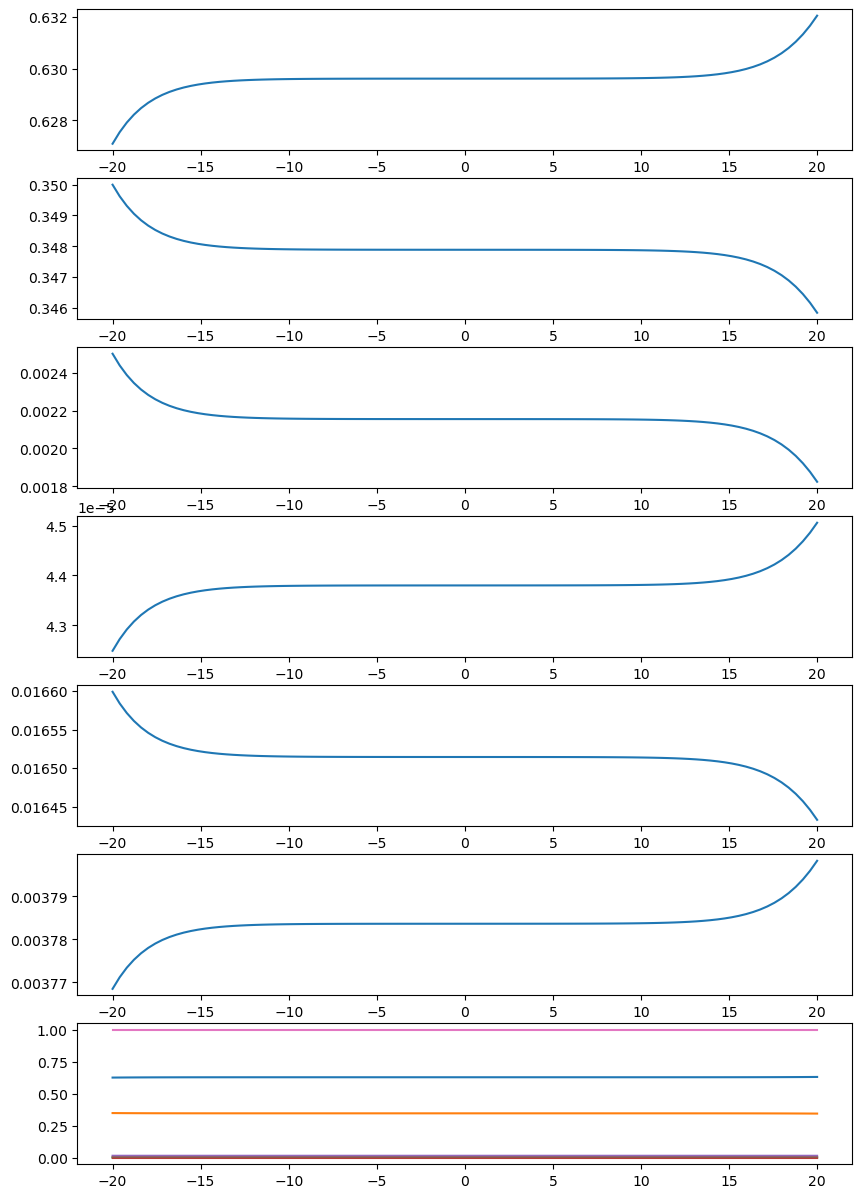

In [6]:
profile_index=20#63
seed=seeds[profile_index]
print(seed)
all_features = np.linspace(-20, 20, 100)
fig, axs=plt.subplots(7, figsize=(10, 15))
#plots with no smoothing
for i in range(6):
    axs[i].plot(all_features, profiles[profile_index].T[i])
    axs[6].plot(all_features, profiles[profile_index].T[i])
axs[6].plot(all_features, np.sum(profiles[profile_index], axis=1))
print(np.sum(profiles[profile_index], axis=1))

[] []
[] []
[]
[]
widths
[]
[]
prominences
[]
[]
total finite:  0
peak info
0
prominent
[] []
[] []
wide
x: [] y: []
x: [] y: []


[] []
[] []
[]
[]
widths
[]
[]
prominences
[]
[]
total finite:  0
peak info
0
prominent
[] []
[] []
wide
x: [] y: []
x: [] y: []


[] []
[] []
[]
[]
widths
[]
[]
prominences
[]
[]
total finite:  0
peak info
0
prominent
[] []
[] []
wide
x: [] y: []
x: [] y: []


[] []
[] []
[]
[]
widths
[]
[]
prominences
[]
[]
total finite:  0
peak info
0
prominent
[] []
[] []
wide
x: [] y: []
x: [] y: []


[] []
[] []
[]
[]
widths
[]
[]
prominences
[]
[]
total finite:  0
peak info
0
prominent
[] []
[] []
wide
x: [] y: []
x: [] y: []


[] []
[] []
[]
[]
widths
[]
[]
prominences
[]
[]
total finite:  0
peak info
0
prominent
[] []
[] []
wide
x: [] y: []
x: [] y: []




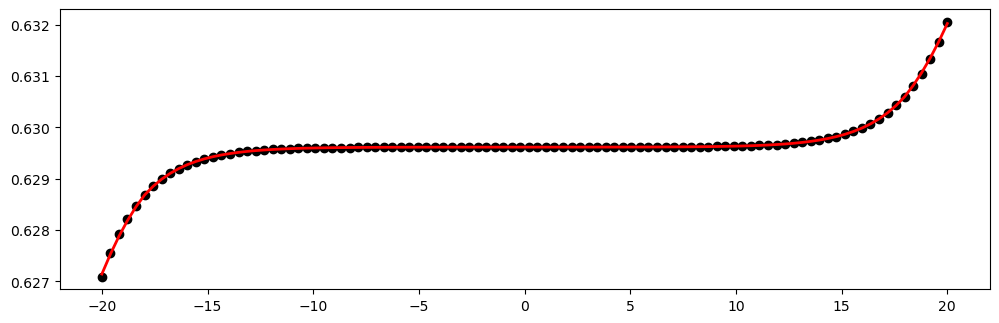

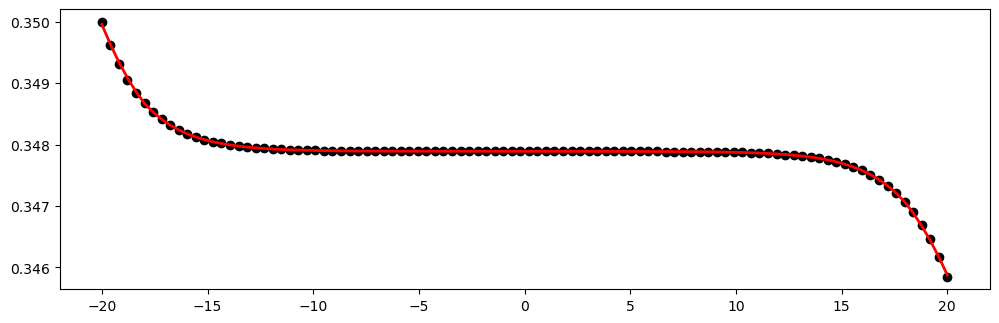

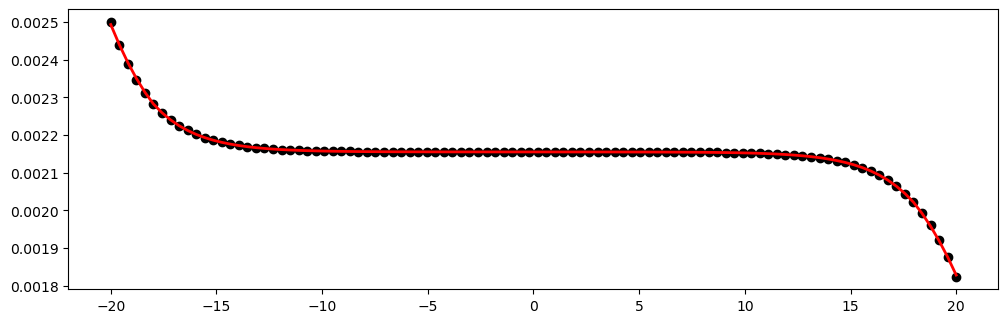

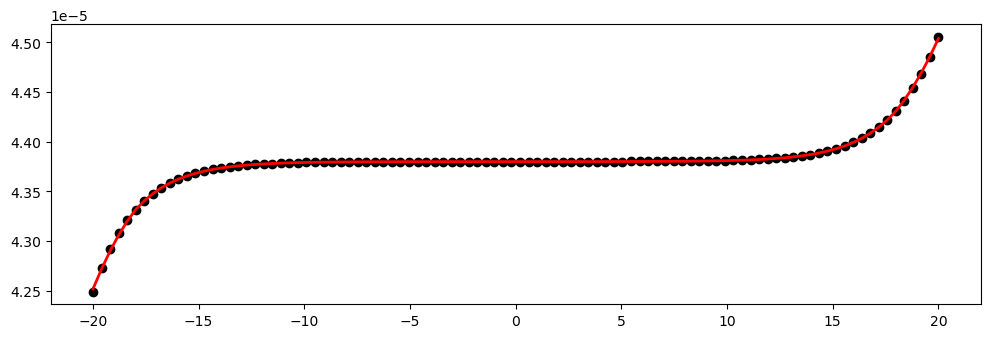

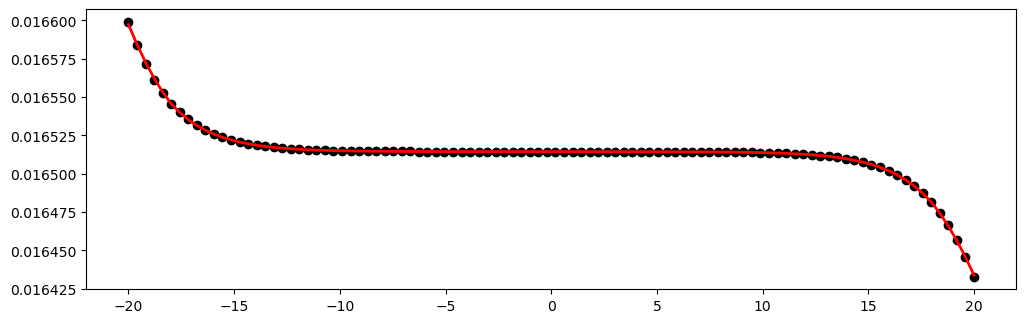

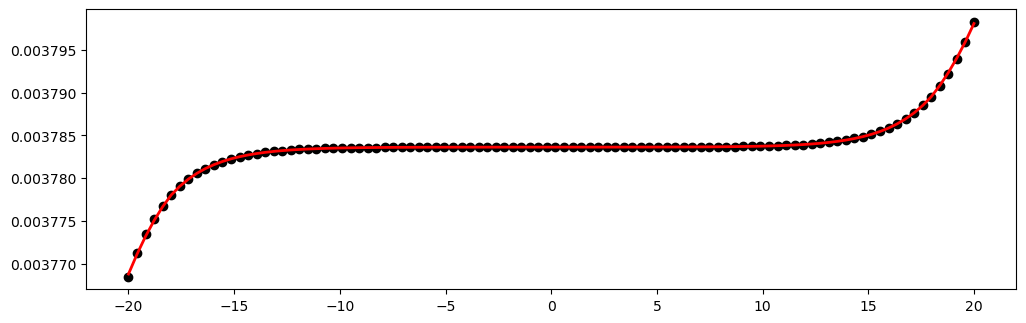

In [7]:
for s in range(6):
    count=count_turning_points_w_plot(profiles[profile_index].T[s], all_features)
    true_count, ex_prominence_peaks, ex_prominence_troughs, ex_width_peaks, ex_width_troughs=turning_points_inputs.count_turning_points(profiles[profile_index].T[s])
    print('peak info')
    print(true_count)
    print('prominent')
    print(all_features[ex_prominence_peaks], profiles[profile_index].T[s][ex_prominence_peaks])
    print(all_features[ex_prominence_troughs], profiles[profile_index].T[s][ex_prominence_troughs])
    print('wide')
    print('x:', all_features[ex_width_peaks], 'y:', profiles[profile_index].T[s][ex_width_peaks])
    print('x:', all_features[ex_width_troughs], 'y:', profiles[profile_index].T[s][ex_width_troughs])
    print('\n')

In [8]:
n_inputs=1
rxn=random_rxn_net(n, m, int(seed), n_second_order, n_inputs, second_order_edge_idxs=np.array([[0,1],[4,1]]))
print(rxn.second_order_edge_reactants)
print(rxn.second_order_edge_prods)
print(rxn.F_a_idxs)

[[0 4]
 [4 3]]
[[1 4]
 [1 3]]
[[2 5]]


In [9]:
params_file=f'../data/turning_points/params_all_N0'#f'data/turning_points/params_all_N3_S0'

f=open(params_file, 'rb')
params_all=pkl.load(f)
f.close()

param=params_all[profile_index % 10000 - 100] #-1 to get 83 for the one that worked
print(profile_index % 10000)

20


In [10]:
F_a=20
initial_conditions = np.log(np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))
all_features = np.linspace(-20, 20, 100)
t_points = np.linspace(0, 20, 200)
solver = 'LSODA'
dt = 0.1
E, B, F = param
max_steps = 1000#000
solns=rxn.integrate(solver=solver, t_points=t_points, dt0=dt, initial_conditions=initial_conditions, args=(E, B, F, F_a,))

/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:80: RuntimeWarning: overflow encountered in exp
  y = np.exp(y)
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:183: RuntimeWarning: invalid value encountered in matmul
  dydt[i] = dydt[i] + W_first_order[i] @ y - np.sum(W_first_order[:, i] * y[i])  # first order reactions
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:183: RuntimeWarning: invalid value encountered in multiply
  dydt[i] = dydt[i] + W_first_order[i] @ y - np.sum(W_first_order[:, i] * y[i])  # first order reactions
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:132: RuntimeWarning: invalid value encountered in scalar multiply
  dydt[i] = dydt[i] + c * term * W[idx_f, idx_i]
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:153: RuntimeWarning: invalid value encountere

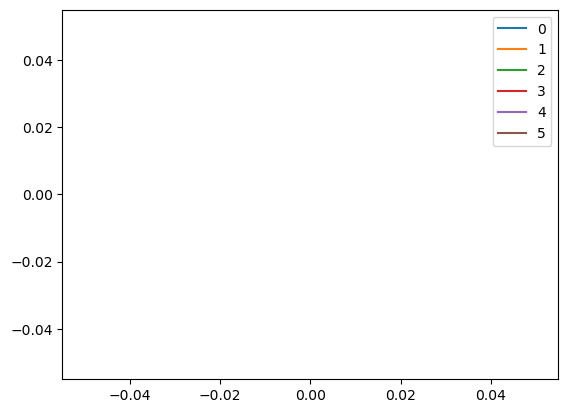

In [11]:
for i in range(6):
    plt.plot(solns.t, np.exp(solns.y[i]), label=f'{i}')
    #plt.plot(solns.t, np.sum(np.exp(solns.y), axis=0))
plt.legend()

/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:80: RuntimeWarning: overflow encountered in exp
  y = np.exp(y)
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:183: RuntimeWarning: invalid value encountered in matmul
  dydt[i] = dydt[i] + W_first_order[i] @ y - np.sum(W_first_order[:, i] * y[i])  # first order reactions
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:183: RuntimeWarning: invalid value encountered in multiply
  dydt[i] = dydt[i] + W_first_order[i] @ y - np.sum(W_first_order[:, i] * y[i])  # first order reactions
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:132: RuntimeWarning: invalid value encountered in scalar multiply
  dydt[i] = dydt[i] + c * term * W[idx_f, idx_i]
/Users/serenadebesai/Documents/second_order_rxn_nets/numpy version/reaction_nets_numpy.py:153: RuntimeWarning: invalid value encountere

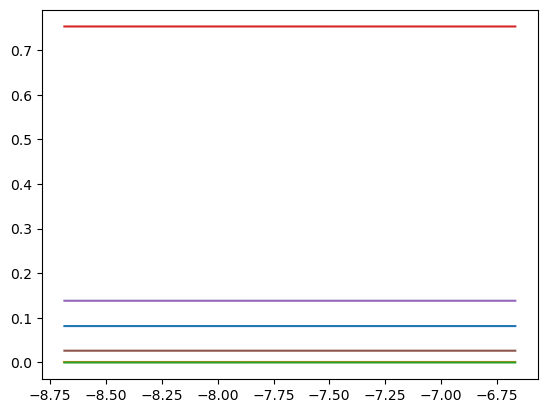

In [14]:
dt0=0.1
profile_test=turning_points.profile(rxn, param, initial_conditions, all_features, solver,t_points, dt0)
for profile in profile_test.T:
    plt.plot(all_features, profile)